In [3]:
# Complete Google Colab Pro Notebook for BTC Volatility Analysis
# Copy each cell into a new Colab notebook

# ============================================
# Cell 1: Check Colab Resources
# ============================================
import os
import multiprocessing
import psutil

# Check available resources
ram_gb = psutil.virtual_memory().total / 1e9
print(f'Available RAM: {ram_gb:.2f} GB')
print(f'Available CPUs: {multiprocessing.cpu_count()}')

# Check GPU if available
try:
    import tensorflow as tf
    print(f'GPU Available: {len(tf.config.list_physical_devices("GPU")) > 0}')
except:
    print('GPU: Not checked')

Available RAM: 13.61 GB
Available CPUs: 2
GPU Available: False


In [1]:
# ============================================
# Cell 2: QuantLib Installation
# ============================================
%%time
print("QuantLib installation...")

# Remove conflicting installations
!apt-get remove -y quantlib-python libquantlib0-dev 2>/dev/null
!pip uninstall -y QuantLib QuantLib-Python 2>/dev/null

# Clean up the problematic system installation
!rm -rf /usr/lib/python3/dist-packages/QuantLib*

# Install fresh QuantLib from pip
print("\nInstalling fresh QuantLib...")
!pip install QuantLib

# Install other dependencies
!pip install -q joblib tqdm matplotlib seaborn psutil pandas numpy scipy

# Test installation
print("\nTesting QuantLib...")
try:
    import QuantLib as ql
    print(f"✓ Success! QuantLib version: {ql.__version__}")

    # Test basic functionality
    today = ql.Date.todaysDate()
    print(f"✓ Basic test passed. Today's date: {today}")

except Exception as e:
    print(f"Error: {e}")
    print("\nIMPORTANT: Please restart the runtime and run from Cell 3")
    print("Click: Runtime -> Restart runtime")

print("\nInstallation complete!")

QuantLib installation...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package 'libquantlib0-dev' is not installed, so not removed
Package 'quantlib-python' is not installed, so not removed
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Found existing installation: QuantLib 1.38
Uninstalling QuantLib-1.38:
  Successfully uninstalled QuantLib-1.38

Installing fresh QuantLib...
  Using cached quantlib-1.38-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.1 kB)
Using cached quantlib-1.38-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (20.0 MB)

Testing QuantLib...
✓ Success! QuantLib version: 1.38
✓ Basic test passed. Today's date: June 8th, 2025

Installation complete!
CPU times: user 356 ms, sys: 70.6 ms, total: 427 ms
Wall time: 21.5 s


In [2]:
# ============================================
# Cell 3: Mount Google Drive and Create Directories
# ============================================
from google.colab import drive
drive.mount('/content/drive')

# Create working directories matching your local structure
!mkdir -p /content/Paper6/Paper_6_News_Effect/1_Modeling
!mkdir -p /content/Paper6/Paper_6_News_Effect/1_Modeling/Data/BTC
!mkdir -p /content/Paper6/Paper_6_News_Effect/1_Modeling/output

Mounted at /content/drive


In [7]:
# ============================================
# Cell Pre4: Remove Python scripts existed or cache
# ============================================
import os
import sys

# Directories to clean scripts from
dirs_to_clean = [
    '/content/Paper6/Paper_6_News_Effect/1_Modeling',
    '/content'  # Root directory
]

print("Cleaning up Python scripts only (keeping data files)...\n")

removed_count = 0

for directory in dirs_to_clean:
    if os.path.exists(directory):
        print(f"Cleaning Python files in {directory}:")

        for file in os.listdir(directory):
            file_path = os.path.join(directory, file)

            # Skip directories
            if os.path.isdir(file_path):
                continue

            # Only remove Python files
            if file.endswith('.py'):
                try:
                    os.remove(file_path)
                    print(f"Removed: {file}")
                    removed_count += 1
                except Exception as e:
                    print(f"Could not remove {file}: {e}")

# Clear Python module cache
modules_to_clear = [
    'bates_utils', 'optimized_bates_utils'
]

print("\nClearing Python module cache:")
for module in modules_to_clear:
    if module in sys.modules:
        del sys.modules[module]
        print(f"Cleared cache: {module}")

print(f"\n Cleanup complete! Removed {removed_count} Python files.")
print(" Data files (.csv) were preserved.")
print("\nYou can now run Cell 4 to upload your updated Python scripts.")

Cleaning up Python scripts only (keeping data files)...

Cleaning Python files in /content/Paper6/Paper_6_News_Effect/1_Modeling:
Removed: bates_utils.py
Removed: colab_main.py
Removed: optimized_bates_utils.py
Cleaning Python files in /content:
Removed: bates_utils.py
Removed: optimized_bates_utils.py

Clearing Python module cache:

 Cleanup complete! Removed 5 Python files.
 Data files (.csv) were preserved.

You can now run Cell 4 to upload your updated Python scripts.


In [8]:
# ============================================
# Cell 4: Upload Your Files From Local
# ============================================
from google.colab import files
import shutil

print("Please upload your Python scripts:")
print("1. bates_utils.py")
print("2. optimized_bates_utils.py")

uploaded = files.upload()

# Save uploaded files to the correct directory
modeling_dir = '/content/Paper6/Paper_6_News_Effect/1_Modeling'
for filename, content in uploaded.items():
    with open(f'{modeling_dir}/{filename}', 'wb') as f:
        f.write(content)
    print(f'Saved {filename}')

Please upload your Python scripts:
1. bates_utils.py
2. optimized_bates_utils.py


Saving bates_utils.py to bates_utils.py
Saving optimized_bates_utils.py to optimized_bates_utils.py
Saved bates_utils.py
Saved optimized_bates_utils.py


In [10]:
# ============================================
# Cell 5: Upload Data Files
# ============================================
from google.colab import files

print("Now upload your data files:")
print("1. BTC_Event_Timeline.csv")
print("2. BTC_event_windows_only.csv")

data_uploaded = files.upload()

# Save data files to the correct directory
data_dir = '/content/Paper6/Paper_6_News_Effect/1_Modeling/Data/BTC'
os.makedirs(data_dir, exist_ok=True)
print(f"Created directory: {data_dir}")

for filename, content in data_uploaded.items():
    with open(f'{data_dir}/{filename}', 'wb') as f:
        f.write(content)
    print(f'Saved {filename} to Data/BTC directory')

# IMPORTANT: Create a symlink with the original filename that your scripts expect
import os

# If the filtered file was uploaded, create a symlink with the original name
if 'BTC_event_windows_only.csv' in data_uploaded:
    # Create symlink so your scripts work without modification
    os.symlink(
        f'{data_dir}/BTC_event_windows_only.csv',
        f'{data_dir}/deribit_options_chain_2021-01-03_OPTIONS.csv'
    )
    print("\n Created symlink: deribit_options_chain_2021-01-03_OPTIONS.csv -> BTC_event_windows_only.csv")
    print("Your scripts will work without any changes!")

# Verify files
print("\nFiles in data directory:")
for f in os.listdir(data_dir):
    file_path = os.path.join(data_dir, f)
    if os.path.isfile(file_path):
        size_mb = os.path.getsize(file_path) / (1024 * 1024)
        print(f"{f} ({size_mb:.1f} MB)")
    elif os.path.islink(file_path):
        print(f"{f} (symlink)")

print("\nReady to proceed with analysis!")

Now upload your data files:
1. BTC_Event_Timeline.csv
2. BTC_event_windows_only.csv


Saving BTC_Event_Timeline.csv to BTC_Event_Timeline.csv
Saving BTC_event_windows_only.csv to BTC_event_windows_only.csv
Created directory: /content/Paper6/Paper_6_News_Effect/1_Modeling/Data/BTC
Saved BTC_Event_Timeline.csv to Data/BTC directory
Saved BTC_event_windows_only.csv to Data/BTC directory

 Created symlink: deribit_options_chain_2021-01-03_OPTIONS.csv -> BTC_event_windows_only.csv
Your scripts will work without any changes!

Files in data directory:
deribit_options_chain_2021-01-03_OPTIONS.csv (233.2 MB)
BTC_Event_Timeline.csv (0.7 MB)
BTC_event_windows_only.csv (233.2 MB)

Ready to proceed with analysis!


In [5]:
# ============================================
# Cell 6: Update Paths in Scripts for Colab
# ============================================
import sys
sys.path.append('/content/Paper6/Paper_6_News_Effect/1_Modeling')

# Create a modified version of the main script with Colab paths
script_content = '''
# Modified version for Colab with updated paths
from bates_utils import (
    clear_environment, clear_console, setup_logging,
    load_events, estimate_jump_contribution,
    calibrate_model, calibrate_heston_model,
    prepare_options, compute_volatility_metrics
)
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import multiprocessing
from tqdm.notebook import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

# Updated paths for Colab
DATA_DIR = Path("/content/Paper6/Paper_6_News_Effect/1_Modeling/Data/BTC")
OUTPUT_DIR = Path("/content/Paper6/Paper_6_News_Effect/1_Modeling/output")
TIMESTAMP_COL = "local_timestamp"

# Use all available CPUs
N_JOBS = multiprocessing.cpu_count()
print(f"Using {N_JOBS} parallel jobs")
'''

# Save the modified script
with open('/content/Paper6/Paper_6_News_Effect/1_Modeling/colab_main.py', 'w') as f:
    f.write(script_content)

In [14]:
# ============================================
# Cell 7: Run the Analysis
# ============================================
%%time
# Import and run your main analysis

import sys
import os
sys.path.append('/content/Paper6/Paper_6_News_Effect/1_Modeling')

# Create output directory if it doesn't exist
OUTPUT_DIR = "/content/Paper6/Paper_6_News_Effect/1_Modeling/output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Import your modules
from bates_utils import (
    clear_environment, clear_console, setup_logging,
    load_events, estimate_jump_contribution,
    #calibrate_model, calibrate_heston_model,
    prepare_options, compute_volatility_metrics,
    filter_intraday_windows, load_btc_options
)

from optimized_bates_utils import (
    calibrate_model_parallel, calibrate_heston_model_parallel
)

from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np
import time
from tqdm.notebook import tqdm

# Configuration with Colab paths
DATA_DIR = Path("/content/Paper6/Paper_6_News_Effect/1_Modeling/Data/BTC")
OUTPUT_DIR = Path("/content/Paper6/Paper_6_News_Effect/1_Modeling/output")
TIMESTAMP_COL = "local_timestamp"

# Setup logging
logger = setup_logging(OUTPUT_DIR, "volatility_analysis_colab.log")

# Your main processing function
def run_analysis():
    start_time = time.time()

    target_date = datetime(2021, 1, 3)
    events = load_events(DATA_DIR, target_date)
    if events.empty:
        print("No events found, exiting.")
        return None

    print(f"Found {len(events)} events to process")

    # Load BTC data
    print("\nLoading pre-filtered BTC options data...")
    btc_data = load_btc_options(
        DATA_DIR,
        "BTC_event_windows_only.csv",
        chunk_size=500000
    )
    print(f"Loaded {len(btc_data):,} option quotes (pre-filtered around events)")

    # Show time range of data
    print(f"Data time range: {btc_data['local_timestamp'].min()} to {btc_data['local_timestamp'].max()}")

    # Process events
    intervals_minutes = [60, 30, 10, 5, 1]  # Or [60, 30, 10, 5, 1] for all intervals
    results = []

    # Process with progress bar
    for idx, (_, row) in tqdm(enumerate(events.iterrows()), total=len(events), desc="Processing events"):
        evt_id, t0 = row.event_id, row.event_time
        windows = filter_intraday_windows(btc_data, t0, intervals_minutes, TIMESTAMP_COL)

        for window_key, window_data in windows.items():
            if len(window_data) < 8:
                continue

            opts = prepare_options(window_data, now=t0)
            if opts.empty:
                continue

            s0 = window_data["underlying_price"].iloc[-1]
            if not np.isfinite(s0):
                continue

            vol = compute_volatility_metrics(window_data, s0, TIMESTAMP_COL)

            # Calibrate models
            for model_type, calibrate_func in [("Bates", calibrate_model_parallel), ("Heston", calibrate_heston_model_parallel)]:
                pars = calibrate_func(opts, s0=s0)
                if pars.get("error"):
                    continue

                result = {
                    "event_id": evt_id,
                    "event_time": t0,
                    "window": window_key,
                    "model_type": model_type,
                    "rmse": pars["rmse"],
                    "realized_vol": vol["realized_vol"],
                    "avg_implied_vol": vol["avg_implied_vol"],
                    "jump_var": estimate_jump_contribution(pars) if model_type == "Bates" else np.nan
                }
                result.update({k: pars.get(k, np.nan) for k in ["v0", "kappa", "theta", "sigma", "rho", "lambdaJ", "muJ", "sigmaJ"]})
                results.append(result)

        # Save intermediate results every 50 events
        if (idx + 1) % 50 == 0:
            temp_df = pd.DataFrame(results)
            temp_df.to_csv(OUTPUT_DIR / f"temp_results_{idx+1}.csv", index=False)
            print(f"Saved intermediate results at event {idx+1}")

    # Save final results
    out_df = pd.DataFrame(results)
    out_path = OUTPUT_DIR / "bates_volatility_intraday_analysis.csv"
    out_df.to_csv(out_path, index=False)

    total_time = time.time() - start_time
    print(f"\n Analysis complete!")
    print(f"Total execution time: {total_time/60:.1f} minutes")
    print(f"Processed {len(results)} windows for {len(events)} events")

    return out_df

# Run the analysis
results_df = run_analysis()

Found 1 events to process

Loading pre-filtered BTC options data...
Loaded 1,003,530 option quotes (pre-filtered around events)
Data time range: 2021-01-03 00:00:00.195032+00:00 to 2021-01-03 01:55:22.999983+00:00


Processing events:   0%|          | 0/1 [00:00<?, ?it/s]


 Analysis complete!
Total execution time: 0.4 minutes
Processed 20 windows for 1 events
CPU times: user 21 s, sys: 836 ms, total: 21.8 s
Wall time: 22 s


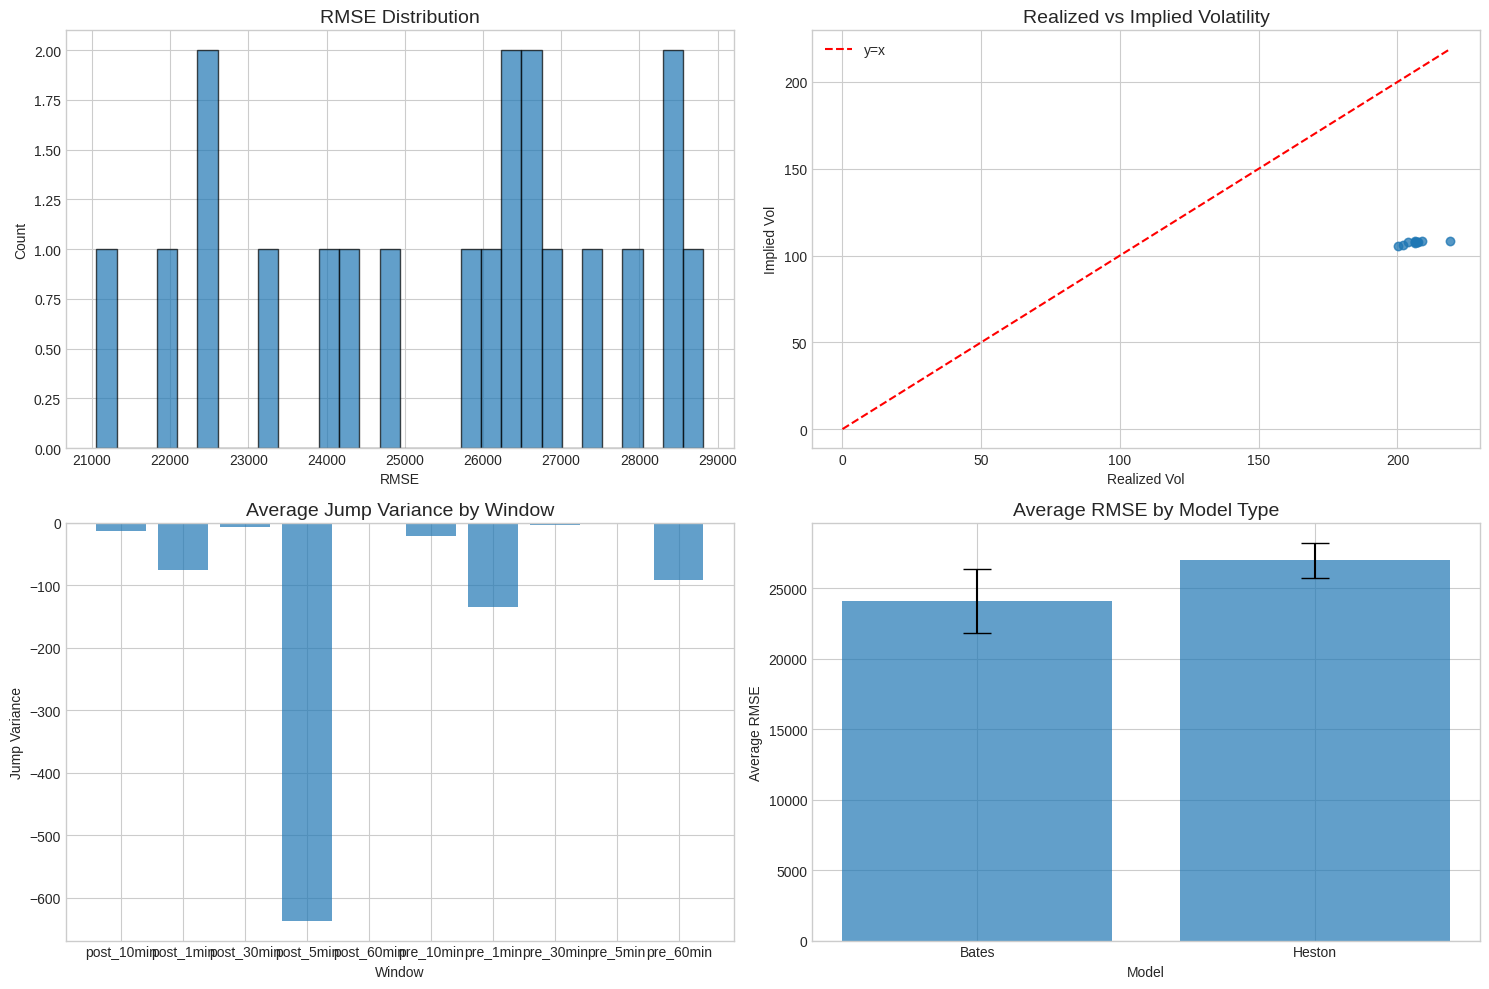


Summary Statistics:
Total events processed: 1
Total windows analyzed: 20

RMSE by Model:
            count          mean          std           min           25%  \
model_type                                                                 
Bates        10.0  24071.443409  2271.904006  21054.992775  22493.321413   
Heston       10.0  26962.526340  1254.807578  24337.128006  26513.059136   

                     50%           75%           max  
model_type                                            
Bates       23640.915437  25660.368648  28465.099248  
Heston      26751.755095  27745.008070  28819.785627  


In [15]:
# ============================================
# Cell 8: Visualize Results
# ============================================
import matplotlib.pyplot as plt
import seaborn as sns

if results_df is not None and not results_df.empty:
    # Set style
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. RMSE Distribution
    axes[0, 0].hist(results_df['rmse'].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[0, 0].set_title('RMSE Distribution', fontsize=14)
    axes[0, 0].set_xlabel('RMSE')
    axes[0, 0].set_ylabel('Count')

    # 2. Volatility Comparison
    axes[0, 1].scatter(results_df['realized_vol'], results_df['avg_implied_vol'], alpha=0.5)
    axes[0, 1].plot([0, results_df[['realized_vol', 'avg_implied_vol']].max().max()],
                    [0, results_df[['realized_vol', 'avg_implied_vol']].max().max()],
                    'r--', label='y=x')
    axes[0, 1].set_title('Realized vs Implied Volatility', fontsize=14)
    axes[0, 1].set_xlabel('Realized Vol')
    axes[0, 1].set_ylabel('Implied Vol')
    axes[0, 1].legend()

    # 3. Jump Variance by Window
    jump_data = results_df[results_df['model_type'] == 'Bates'].groupby('window')['jump_var'].mean()
    if not jump_data.empty:
        axes[1, 0].bar(jump_data.index, jump_data.values, alpha=0.7)
        axes[1, 0].set_title('Average Jump Variance by Window', fontsize=14)
        axes[1, 0].set_xlabel('Window')
        axes[1, 0].set_ylabel('Jump Variance')

    # 4. Model Comparison
    model_rmse = results_df.groupby('model_type')['rmse'].agg(['mean', 'std'])
    axes[1, 1].bar(model_rmse.index, model_rmse['mean'], yerr=model_rmse['std'], capsize=10, alpha=0.7)
    axes[1, 1].set_title('Average RMSE by Model Type', fontsize=14)
    axes[1, 1].set_xlabel('Model')
    axes[1, 1].set_ylabel('Average RMSE')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nSummary Statistics:")
    print("="*50)
    print(f"Total events processed: {len(results_df['event_id'].unique())}")
    print(f"Total windows analyzed: {len(results_df)}")
    print(f"\nRMSE by Model:")
    print(results_df.groupby('model_type')['rmse'].describe())

In [16]:
# ============================================
# Cell 9: Save Results to Google Drive
# ============================================
if results_df is not None:
    # Save to Google Drive for persistence
    drive_path = "/content/drive/MyDrive/BTC_Analysis_Results"
    !mkdir -p {drive_path}

    # Save results
    results_df.to_csv(f"{drive_path}/bates_volatility_intraday_analysis.csv", index=False)
    print(f"Results saved to Google Drive: {drive_path}")

    # Create summary report
    summary = f"""
Analysis Summary
================
Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Total events processed: {len(results_df['event_id'].unique())}
Total windows analyzed: {len(results_df)}

Volatility Metrics:
- Average realized volatility: {results_df['realized_vol'].mean():.4f}
- Average implied volatility: {results_df['avg_implied_vol'].mean():.4f}

Model Performance:
{results_df.groupby('model_type')['rmse'].agg(['mean', 'std', 'min', 'max'])}

Jump Parameters (Bates Model):
- Average jump intensity (lambda): {results_df[results_df['model_type']=='Bates']['lambdaJ'].mean():.4f}
- Average jump mean (mu): {results_df[results_df['model_type']=='Bates']['muJ'].mean():.4f}
- Average jump volatility (sigma): {results_df[results_df['model_type']=='Bates']['sigmaJ'].mean():.4f}
"""

    # Save summary
    with open(f'{drive_path}/analysis_summary.txt', 'w') as f:
        f.write(summary)

    print("\n" + summary)

Results saved to Google Drive: /content/drive/MyDrive/BTC_Analysis_Results


Analysis Summary
Date: 2025-06-08 20:26:02
Total events processed: 1
Total windows analyzed: 20

Volatility Metrics:
- Average realized volatility: 206.6757
- Average implied volatility: 107.5163

Model Performance:
                    mean          std           min           max
model_type                                                       
Bates       24071.443409  2271.904006  21054.992775  28465.099248
Heston      26962.526340  1254.807578  24337.128006  28819.785627

Jump Parameters (Bates Model):
- Average jump intensity (lambda): -5.1585
- Average jump mean (mu): 1.9499
- Average jump volatility (sigma): 1.9683



In [17]:
# ============================================
# Cell 10: Download Results
# ============================================
from google.colab import files

if results_df is not None:
    # Download the results
    files.download('/content/Paper6/Paper_6_News_Effect/1_Modeling/output/bates_volatility_intraday_analysis.csv')
    print("Results downloaded successfully!")
else:
    print("No results to download")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Results downloaded successfully!
